In [1]:
import pandas as pd
import numpy as np
import json

In [13]:
# this part use to clean the similarity vectors for the patent with float 'nan' Abstract
def get_useless_set(patent_data):
    useless_set = set()
    for key in patent_data:
        if type(patent_data[key]['Abstract'])==float:
            useless_set.add(key)
    return useless_set

def clean_abstract(df,useless_set):
    mask1 = []
    mask2 = []
    for i in range(len(df)):
        if (df.iloc[i]['Plaintiff_Patent'] in useless_set) and (df.iloc[i]['Plaintiff_Category']=='Abstract'):
            mask1.append(True)
        else:
            mask1.append(False)

        if (df.iloc[i]['Defendant_Patent'] in useless_set) and (df.iloc[i]['Defendant_Category']=='Abstract'):
            mask2.append(True)
        else:
            mask2.append(False)
        
    mask = np.array(mask1)+np.array(mask2)
    
    df_new = df[~mask]
    
    return df_new

# this function transform the cleaned data into training data
def get_train_data(raw_df,df_label):
    # process the raw data df
    raw_df = raw_df[['Plaintiff_Patent','Defendant_Patent','Plaintiff_Category','Defendant_Category','Similarity_Score']]
    raw_df = raw_df.replace(r'Claim_Set\S*','Claim',regex=True)
    # groupby all the claim in one patent to get average score
    raw_df = pd.DataFrame(raw_df.groupby(['Plaintiff_Patent','Defendant_Patent','Plaintiff_Category','Defendant_Category']).agg('max').reset_index())
    
    # transform in to the training form
    train_vec_df = pd.DataFrame(columns=['P_Ab_D_Ab','P_Ab_D_Dis','P_Ab_D_Fig','P_Ab_D_Cla','P_Dis_D_Ab','P_Dis_D_Dis','P_Dis_D_Fig','P_Dis_D_Cla',\
                     'P_Fig_D_Ab','P_Fig_D_Dis','P_Fig_D_Fig','P_Fig_D_Cla','P_Cla_D_Ab','P_Cla_D_Dis','P_Cla_D_Fig','P_Cla_D_Cla','Plaintiff','Defendant','Label'])
    train_vec_set = set()
    pair_no = 0
    ref_dict = {'Abstract':1,'Disclosure':2,'Figures_Desc':3,'Claim':4}
    for i in range(len(raw_df)):
        pair = (raw_df.iloc[i]['Plaintiff_Patent'],raw_df.iloc[i]['Defendant_Patent'])
        # if new pair, then creat new row
        if pair not in train_vec_set:
            train_vec_set.add(pair)
            train_vec_df.loc[pair_no] = np.nan

            train_vec_df['Plaintiff'][pair_no] = raw_df.iloc[i]['Plaintiff_Patent']
            train_vec_df['Defendant'][pair_no] = raw_df.iloc[i]['Defendant_Patent']
            label = df_label[df_label['Pair']==pair]['Label'].values[0]
            train_vec_df['Label'][pair_no] = 1 if label else 0
            pair_no+=1

        col = ref_dict[raw_df['Plaintiff_Category'][i]]
        row = ref_dict[raw_df['Defendant_Category'][i]]
        position = col+(row-1)*4-1
        train_vec_df.iloc[pair_no-1,position] = raw_df['Similarity_Score'][i]
        
    # fillna with average of rows
    train_vec_df = train_vec_df.T.fillna(train_vec_df.iloc[:,:16].apply(lambda x:x.mean(),axis =1)).T
    #train_vec_df = train_vec_df.fillna(0)
    return train_vec_df

In [3]:
# load data dictionary
with open("patent_data.json",'r', encoding='UTF-8') as f:
     patent_data = json.load(f)

In [4]:
# load the label data
df_label = pd.read_csv('Simplified_training_data_new.csv')
df_label["Pair"]=df_label[["plaintiff_patent","defendant_patent"]].apply(lambda x:(x["plaintiff_patent"],x["defendant_patent"]),axis=1)

In [5]:
df_label

,plaintiff_patent,defendant_patent,Label,Pair
0,US5897576A,WO2012063215A2,True,"(US5897576A, WO2012063215A2)"
1,US5897576A,US20130213840A1,True,"(US5897576A, US20130213840A1)"
2,US5897576A,US8985326B2,True,"(US5897576A, US8985326B2)"
3,US5897576A,WO2012063215A3,True,"(US5897576A, WO2012063215A3)"
4,US4810123A,USD417552S,True,"(US4810123A, USD417552S)"
...,...,...,...,...
7087,US5552922A,US10379265B2,False,"(US5552922A, US10379265B2)"
7088,US5552922A,US10409079B2,False,"(US5552922A, US10409079B2)"
7089,US5552922A,WO2019220978A1,False,"(US5552922A, WO2019220978A1)"
7090,US5552922A,WO2019220974A1,False,"(US5552922A, WO2019220974A1)"


In [91]:
df0 = pd.read_csv('Pairs_Part_Scores0-999.csv')
df1 = pd.read_csv('Pairs_Part_Scores6100-6300.csv')
df2 = pd.read_csv('Pairs_Part_Scores6370-6414.csv')
df3 = pd.read_csv('Pairs_Part_Scores6370-6414.csv')
df4 = pd.read_csv('Pairs_Part_Scores6415-6434.csv')
df5 = pd.read_csv('Pairs_Part_Scores6600-6649.csv')
df6 = pd.read_csv('Pairs_Part_Scores6650-6700.csv')
df7 = pd.read_csv('Pairs_Part_Scores6700-6725.csv')
df8 = pd.read_csv('Pairs_Part_Scores6725-6750.csv')
df9 = pd.read_csv('Pairs_Part_Scores6750-6775.csv')
df = pd.concat([df0,df1,df2,df3,df4,df5,df6,df7,df8,df9])
df.to_csv('all_data.csv')

In [14]:
# clean the data
df_needtoclean = pd.read_csv('Pairs_Part_Scores0-999.csv')
useless_set = get_useless_set(patent_data)
df_clean = clean_abstract(df_needtoclean,useless_set)

In [15]:
# transform the data into training data
train_df = get_train_data(df_clean,df_label)
train_df = train_df.iloc[:425,]
train_df

,P_Ab_D_Ab,P_Ab_D_Dis,P_Ab_D_Fig,P_Ab_D_Cla,P_Dis_D_Ab,P_Dis_D_Dis,P_Dis_D_Fig,P_Dis_D_Cla,P_Fig_D_Ab,P_Fig_D_Dis,P_Fig_D_Fig,P_Fig_D_Cla,P_Cla_D_Ab,P_Cla_D_Dis,P_Cla_D_Fig,P_Cla_D_Cla,Plaintiff,Defendant,Label
0,0.77961,0.797552,0.754302,0.727246,0.660613,0.867547,0.754302,0.762207,0.754302,0.754302,0.754302,0.754302,0.674696,0.751513,0.754302,0.767735,US4743450A,US6333332B1,1
1,0.789193,0.736205,0.704583,0.588565,0.746543,0.751686,0.74173,0.676087,0.736495,0.808431,0.793646,0.683686,0.66528,0.734646,0.708107,0.717434,US4810123A,US20070110505A1,1
2,0.668762,0.714769,0.680579,0.592801,0.622362,0.758029,0.648325,0.626596,0.763935,0.817506,0.835439,0.671262,0.653203,0.731148,0.661024,0.696099,US4810123A,US20070147943A1,1
3,0.808785,0.783067,0.76185,0.614633,0.806264,0.821087,0.798183,0.651307,0.8114,0.842358,0.841875,0.656517,0.751621,0.790261,0.790589,0.695892,US4810123A,US20080193196A1,1
4,0.725416,0.705844,0.683442,0.600402,0.689084,0.791123,0.73583,0.623654,0.747385,0.813764,0.819809,0.652946,0.646479,0.781849,0.719544,0.669104,US4810123A,US7192210B2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,0.76337,0.723648,0.736616,0.679508,0.745908,0.805342,0.847189,0.79004,0.714351,0.800292,0.800702,0.728165,0.626478,0.654829,0.686187,0.744372,US6328341B2,US6619480B2,1
421,0.794288,0.6566,0.691538,0.610717,0.752268,0.844635,0.850636,0.785638,0.740547,0.796617,0.856902,0.789558,0.692475,0.747011,0.76557,0.80301,US6328341B2,US6957737B1,1
422,0.799967,0.744732,0.792484,0.69353,0.791172,0.839816,0.846116,0.777976,0.75063,0.823104,0.852567,0.755372,0.708111,0.771214,0.779704,0.780571,US6328341B2,US7000844B1,1
423,1,0.880112,0.776791,0.884832,0.888315,0.960664,0.861812,0.877338,0.76344,0.89454,1,0.832833,0.865549,0.9047,0.881497,0.928372,US6336311B1,US6047530A,1


In [16]:
# import datasets with label as no ifringement
df1 = pd.read_csv('Pairs_Part_Scores6100-6300.csv')
df2 = pd.read_csv('Pairs_Part_Scores6370-6414.csv')
df3 = pd.read_csv('Pairs_Part_Scores6370-6414.csv')
df4 = pd.read_csv('Pairs_Part_Scores6415-6434.csv')
df5 = pd.read_csv('Pairs_Part_Scores6600-6649.csv')
df6 = pd.read_csv('Pairs_Part_Scores6650-6700.csv')
df7 = pd.read_csv('Pairs_Part_Scores6700-6725.csv')
df8 = pd.read_csv('Pairs_Part_Scores6725-6750.csv')
df9 = pd.read_csv('Pairs_Part_Scores6750-6775.csv')
df_needtoclean = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9])
df_needtoclean

,Unnamed: 0,Plaintiff_Patent,Defendant_Patent,Plaintiff_Category,Defendant_Category,Similarity_Score
0,0,US5897576A,US7930023B2,Abstract,Abstract,0.836458
1,1,US5897576A,US7930023B2,Abstract,Claim_Set_1,0.718566
2,2,US5897576A,US7930023B2,Abstract,Claim_Set_2,0.729100
3,3,US5897576A,US7930023B2,Abstract,Figures_Desc,0.781000
4,4,US5897576A,US7930023B2,Abstract,Disclosure,0.807666
...,...,...,...,...,...,...
1251,1251,US5490523A,US20090168050A1,Disclosure,Claim_Set_1,0.548377
1252,1252,US5490523A,US20090168050A1,Disclosure,Claim_Set_2,0.697842
1253,1253,US5490523A,US20090168050A1,Disclosure,Claim_Set_3,0.738032
1254,1254,US5490523A,US20090168050A1,Disclosure,Figures_Desc,0.816627


In [17]:
# clean the data
useless_set = get_useless_set(patent_data)
df_clean = clean_abstract(df_needtoclean,useless_set)
# transform the data into training data
train_df2 = get_train_data(df_clean,df_label)
train_df2

,P_Ab_D_Ab,P_Ab_D_Dis,P_Ab_D_Fig,P_Ab_D_Cla,P_Dis_D_Ab,P_Dis_D_Dis,P_Dis_D_Fig,P_Dis_D_Cla,P_Fig_D_Ab,P_Fig_D_Dis,P_Fig_D_Fig,P_Fig_D_Cla,P_Cla_D_Ab,P_Cla_D_Dis,P_Cla_D_Fig,P_Cla_D_Cla,Plaintiff,Defendant,Label
0,0.500269,0.527367,0.508344,0.54412,0.584529,0.659761,0.679807,0.686924,0.579098,0.579098,0.579098,0.579098,0.517287,0.568857,0.551308,0.620599,US4810123A,GB2094443A,0
1,0.284685,0.28564,0.407986,0.244822,0.242512,0.418439,0.290942,0.326287,0.312664,0.312664,0.312664,0.312664,0.312664,0.312664,0.312664,0.312664,US4810123A,GB735590A,0
2,0.679979,0.679979,0.679979,0.679979,0.679979,0.679979,0.679979,0.679979,0.679979,0.679979,0.679979,0.679979,0.669422,0.722322,0.695964,0.632208,US4810123A,US3231151A,0
3,0.761592,0.761592,0.761592,0.761592,0.761592,0.761592,0.761592,0.761592,0.761592,0.761592,0.761592,0.761592,0.772458,0.794806,0.825068,0.654038,US4810123A,US3337899A,0
4,0.667938,0.712374,0.725286,0.605659,0.679663,0.823015,0.824192,0.627768,0.708237,0.708237,0.708237,0.708237,0.708237,0.708237,0.708237,0.708237,US4810123A,US3554659A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,0.56573,0.637829,0.618685,0.5653,0.556659,0.65616,0.65522,0.605158,0.631466,0.714634,0.751539,0.679108,0.510472,0.625745,0.622994,0.614138,US6393587B2,US7085802B1,0
421,0.717215,0.656966,0.681035,0.584959,0.760801,0.804363,0.806169,0.781464,0.71493,0.78795,0.842693,0.747013,0.62949,0.708517,0.749408,0.757877,US6393587B2,US7206831B1,0
422,0.605563,0.575858,0.529389,0.509513,0.572737,0.671597,0.651212,0.620218,0.612183,0.708416,0.723572,0.655115,0.544282,0.619338,0.625934,0.651953,US6393587B2,US8107822B2,0
423,0.520046,0.418458,0.470552,0.395241,0.473916,0.614392,0.528178,0.517052,0.511329,0.612951,0.648564,0.553777,0.442141,0.52014,0.514533,0.543983,US6393587B2,US8213333B2,0


In [92]:
x_train = train_df.append(train_df2)
x_train.to_csv('x_train.csv')
x_train

,P_Ab_D_Ab,P_Ab_D_Dis,P_Ab_D_Fig,P_Ab_D_Cla,P_Dis_D_Ab,P_Dis_D_Dis,P_Dis_D_Fig,P_Dis_D_Cla,P_Fig_D_Ab,P_Fig_D_Dis,P_Fig_D_Fig,P_Fig_D_Cla,P_Cla_D_Ab,P_Cla_D_Dis,P_Cla_D_Fig,P_Cla_D_Cla,Plaintiff,Defendant,Label
0,0.77961,0.797552,0.754302,0.727246,0.660613,0.867547,0.754302,0.762207,0.754302,0.754302,0.754302,0.754302,0.674696,0.751513,0.754302,0.767735,US4743450A,US6333332B1,1
1,0.789193,0.736205,0.704583,0.588565,0.746543,0.751686,0.74173,0.676087,0.736495,0.808431,0.793646,0.683686,0.66528,0.734646,0.708107,0.717434,US4810123A,US20070110505A1,1
2,0.668762,0.714769,0.680579,0.592801,0.622362,0.758029,0.648325,0.626596,0.763935,0.817506,0.835439,0.671262,0.653203,0.731148,0.661024,0.696099,US4810123A,US20070147943A1,1
3,0.808785,0.783067,0.76185,0.614633,0.806264,0.821087,0.798183,0.651307,0.8114,0.842358,0.841875,0.656517,0.751621,0.790261,0.790589,0.695892,US4810123A,US20080193196A1,1
4,0.725416,0.705844,0.683442,0.600402,0.689084,0.791123,0.73583,0.623654,0.747385,0.813764,0.819809,0.652946,0.646479,0.781849,0.719544,0.669104,US4810123A,US7192210B2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,0.56573,0.637829,0.618685,0.5653,0.556659,0.65616,0.65522,0.605158,0.631466,0.714634,0.751539,0.679108,0.510472,0.625745,0.622994,0.614138,US6393587B2,US7085802B1,0
421,0.717215,0.656966,0.681035,0.584959,0.760801,0.804363,0.806169,0.781464,0.71493,0.78795,0.842693,0.747013,0.62949,0.708517,0.749408,0.757877,US6393587B2,US7206831B1,0
422,0.605563,0.575858,0.529389,0.509513,0.572737,0.671597,0.651212,0.620218,0.612183,0.708416,0.723572,0.655115,0.544282,0.619338,0.625934,0.651953,US6393587B2,US8107822B2,0
423,0.520046,0.418458,0.470552,0.395241,0.473916,0.614392,0.528178,0.517052,0.511329,0.612951,0.648564,0.553777,0.442141,0.52014,0.514533,0.543983,US6393587B2,US8213333B2,0


In [51]:
# using avg
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

x = x_train.iloc[:,:16].astype(float)
y = x_train['Label'].astype(int)

x=(x-x.mean())/x.std()

x.describe()

,P_Ab_D_Ab,P_Ab_D_Dis,P_Ab_D_Fig,P_Ab_D_Cla,P_Dis_D_Ab,P_Dis_D_Dis,P_Dis_D_Fig,P_Dis_D_Cla,P_Fig_D_Ab,P_Fig_D_Dis,P_Fig_D_Fig,P_Fig_D_Cla,P_Cla_D_Ab,P_Cla_D_Dis,P_Cla_D_Fig,P_Cla_D_Cla
count,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02
mean,-2.082125e-15,-3.250341e-15,-2.398604e-15,2.282619e-15,-3.328318e-15,1.529602e-15,1.803916e-15,-3.215075e-16,-1.738609e-15,-3.592029e-15,4.615001e-15,6.018584e-15,3.731656e-16,-6.522887e-16,2.449413e-15,-1.326521e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.989339e+00,-3.738503e+00,-3.917620e+00,-3.454550e+00,-4.391297e+00,-5.262950e+00,-4.334303e+00,-4.656558e+00,-4.072677e+00,-4.475443e+00,-4.179032e+00,-4.626583e+00,-3.904659e+00,-4.389973e+00,-4.575242e+00,-4.091704e+00
25%,-5.587384e-01,-5.310160e-01,-4.980278e-01,-5.724134e-01,-5.407795e-01,-3.869058e-01,-5.149766e-01,-4.106083e-01,-5.454968e-01,-4.154667e-01,-4.369498e-01,-3.909914e-01,-5.658805e-01,-5.066065e-01,-4.659724e-01,-4.751289e-01
50%,5.478704e-02,1.427004e-01,9.313223e-02,7.343575e-02,2.383808e-01,1.603088e-01,1.203062e-01,1.668512e-01,2.205564e-01,9.828811e-02,2.130915e-03,1.321835e-01,1.580758e-01,1.572940e-01,1.374600e-01,1.908932e-01
75%,6.660100e-01,7.143848e-01,7.364080e-01,7.087607e-01,7.203989e-01,6.456384e-01,7.086920e-01,6.426454e-01,7.358701e-01,6.165335e-01,6.711529e-01,6.611255e-01,7.412486e-01,6.774056e-01,7.079191e-01,6.802579e-01
max,2.481459e+00,1.900617e+00,2.126809e+00,2.464504e+00,1.607202e+00,1.874865e+00,1.947959e+00,1.675387e+00,1.990959e+00,1.720657e+00,2.115523e+00,1.876753e+00,2.273030e+00,1.894307e+00,1.963343e+00,2.027716e+00


In [84]:
X_train,X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1)

In [95]:
# model = LogisticRegression(random_state=0).fit(X_train, y_train)
model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
predictions = model.predict(sm.add_constant(X_test))
predictions_1 = list(map(round, predictions))

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.542240
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                  680
Model:                          Logit   Df Residuals:                      663
Method:                           MLE   Df Model:                           16
Date:                Fri, 11 Mar 2022   Pseudo R-squ.:                  0.2176
Time:                        15:49:05   Log-Likelihood:                -368.72
converged:                       True   LL-Null:                       -471.27
Covariance Type:            nonrobust   LLR p-value:                 7.420e-35
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0680      0.093     -0.729      0.466      -0.251       0.115
P_Ab_D_Ab       0.5128    

In [96]:
print(model.params)

const         -0.067996
P_Ab_D_Ab      0.512782
P_Ab_D_Dis    -0.155185
P_Ab_D_Fig    -1.318684
P_Ab_D_Cla     1.050658
P_Dis_D_Ab    -0.243397
P_Dis_D_Dis    0.172577
P_Dis_D_Fig    1.605217
P_Dis_D_Cla   -0.577305
P_Fig_D_Ab    -1.151687
P_Fig_D_Dis   -1.027062
P_Fig_D_Fig    0.683892
P_Fig_D_Cla    0.473803
P_Cla_D_Ab     0.387158
P_Cla_D_Dis    1.671954
P_Cla_D_Fig    0.313708
P_Cla_D_Cla   -1.946009
dtype: float64


In [86]:
from sklearn.metrics import (confusion_matrix,accuracy_score)

# confusion matrix
cm = confusion_matrix(y_test, predictions_1)
print ("Confusion Matrix : \n", cm)
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, predictions_1))

Confusion Matrix : 
 [[61 29]
 [13 67]]
Test accuracy =  0.7529411764705882


In [87]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predictions)

0.8144444444444445

In [100]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(y_test, predictions_1))
print('Recall: %.3f' % recall_score(y_test, predictions_1))
print('Accuracy: %.3f' % accuracy_score(y_test, predictions_1))
print('F1 Score: %.3f' % f1_score(y_test, predictions_1))
print('AUC Score: %.3f' % roc_auc_score(y_test, predictions))

Precision: 0.714
Recall: 0.812
Accuracy: 0.759
F1 Score: 0.760
AUC Score: 0.813


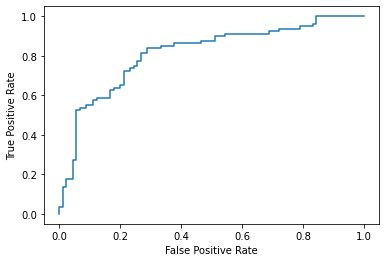

In [98]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  predictions)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
import seaborn as sn
import matplotlib.pyplot as plt

In [62]:
corr_df=x_train.loc[:, ~x_train.columns.isin(['Plaintiff', 'Defendant', 'Label','index'])].reset_index()
corr_df=corr_df.loc[:, ~corr_df.columns.isin(['index'])]
corrMatrix = corr_df.astype(float).corr()
corrMatrix

,P_Ab_D_Ab,P_Ab_D_Dis,P_Ab_D_Fig,P_Ab_D_Cla,P_Dis_D_Ab,P_Dis_D_Dis,P_Dis_D_Fig,P_Dis_D_Cla,P_Fig_D_Ab,P_Fig_D_Dis,P_Fig_D_Fig,P_Fig_D_Cla,P_Cla_D_Ab,P_Cla_D_Dis,P_Cla_D_Fig,P_Cla_D_Cla
P_Ab_D_Ab,1.000000,0.889372,0.825018,0.862513,0.698459,0.627830,0.765195,0.686103,0.771307,0.724451,0.799054,0.805379,0.731411,0.736151,0.801551,0.743595
P_Ab_D_Dis,0.889372,1.000000,0.870844,0.922536,0.625508,0.620739,0.769519,0.675651,0.719036,0.680396,0.763049,0.784904,0.674582,0.736797,0.788767,0.720800
P_Ab_D_Fig,0.825018,0.870844,1.000000,0.863413,0.730077,0.733757,0.736997,0.733088,0.799450,0.743138,0.722393,0.798717,0.746594,0.791926,0.825025,0.721983
P_Ab_D_Cla,0.862513,0.922536,0.863413,1.000000,0.631996,0.596512,0.720884,0.700936,0.710506,0.653483,0.737772,0.775610,0.678105,0.700746,0.761097,0.723269
P_Dis_D_Ab,0.698459,0.625508,0.730077,0.631996,1.000000,0.853186,0.771956,0.870198,0.882728,0.728405,0.703590,0.777344,0.777259,0.712979,0.763530,0.653621
P_Dis_D_Dis,0.627830,0.620739,0.733757,0.596512,0.853186,1.000000,0.760331,0.880707,0.772636,0.708093,0.687605,0.764042,0.656177,0.758249,0.737003,0.633304
P_Dis_D_Fig,0.765195,0.769519,0.736997,0.720884,0.771956,0.760331,1.000000,0.843594,0.759207,0.742555,0.841739,0.839880,0.702764,0.753784,0.852653,0.787960
P_Dis_D_Cla,0.686103,0.675651,0.733088,0.700936,0.870198,0.880707,0.843594,1.000000,0.782466,0.718707,0.758484,0.839827,0.695507,0.745508,0.783839,0.755524
P_Fig_D_Ab,0.771307,0.719036,0.799450,0.710506,0.882728,0.772636,0.759207,0.782466,1.000000,0.805396,0.735578,0.852462,0.811948,0.749996,0.796696,0.689801
P_Fig_D_Dis,0.724451,0.680396,0.743138,0.653483,0.728405,0.708093,0.742555,0.718707,0.805396,1.000000,0.862545,0.901143,0.665200,0.726836,0.772003,0.717431


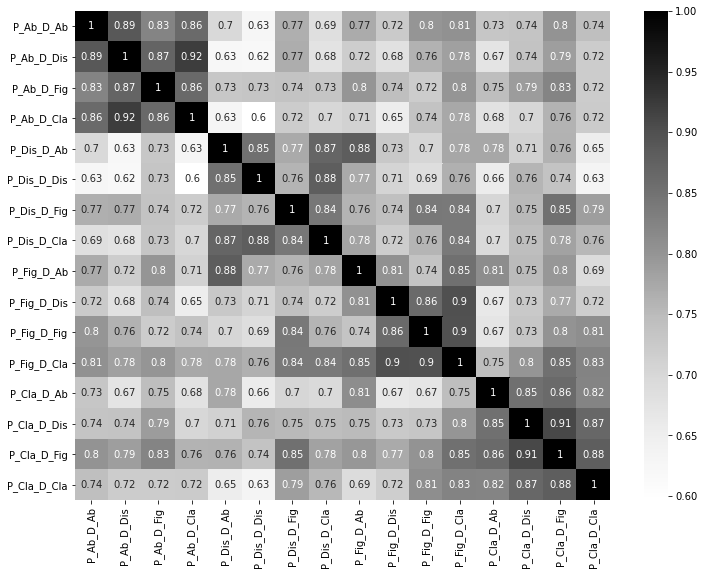

In [63]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(9)
sn.heatmap(corrMatrix, annot=True, cmap="Greys")
plt.show()